In [1]:
from pathlib import Path
import os
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Load the Data

In [2]:
# Access data folder
path = Path('../Data/Raw/')
os.chdir(path)

In [3]:
files = os.listdir()
dataframes = []

for file in files:
    
    stringEnd = len(file) - 4 # remove '.csv' from file names
    sourceName = file[0:stringEnd] # retrieves data source name
    
    df = pd.read_csv(file, low_memory=False)
    df.insert(0, 'data_source', sourceName) # create data source column and insert source name
    
    dataframes.append(df)

# Clean the data

### Remove unnecessary columns

For the purpose of this project, `date_added`, `country` and `show_id` are not needed in the analysis and so can be removed from the streaming service datasets

In [4]:
for df in dataframes:
    print(df['data_source'].unique())
    df.info()

['amazon_prime_titles']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9668 entries, 0 to 9667
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   data_source   9668 non-null   object
 1   show_id       9668 non-null   object
 2   type          9668 non-null   object
 3   title         9668 non-null   object
 4   director      7586 non-null   object
 5   cast          8435 non-null   object
 6   country       672 non-null    object
 7   date_added    155 non-null    object
 8   release_year  9668 non-null   int64 
 9   rating        9331 non-null   object
 10  duration      9668 non-null   object
 11  listed_in     9668 non-null   object
 12  description   9668 non-null   object
dtypes: int64(1), object(12)
memory usage: 982.0+ KB
['disney_plus_titles']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------   

In [5]:
colsToRemove = ['date_added', 'country', 'show_id']

for df in dataframes:
    for column in colsToRemove:
        if column in df.columns:
            df.drop(columns=column, inplace=True)
        else:
            continue

### Remove records with null key information

The `director`, `cast` and `description` columns provide useful additional information to the end-user and so will be retained as part of drill down reports in the dashboard

All datasets however must have the below information for analysis. So, any rows with null against any of these columns will be dropped from the dataset
- rating
- release_year
- duration
- listed_in

In [6]:
colsToCheck = ['rating', 'release_year', 'duration', 'listed_in']

In [7]:
for df in dataframes:
    df.dropna(how='any', subset=colsToCheck, inplace=True)

The `Amazon` dataset has rows with `UNRATED` and `NOT_RATE` values under the `rating` column - these need to be excluded

In [8]:
condition = dataframes[0].loc[(dataframes[0]['rating'] == 'UNRATED') | (dataframes[0]['rating'] == 'NOT_RATE')]
dataframes[0].drop(condition.index, inplace=True)

# Transform the Data

To facilitate converting datatypes, a function is created

In [9]:
def convertDatatypes(df, col, dtype):
    
    df[col] = df[col].astype(dtype)
    
    return df

### The three streaming service datasets will be transformed into the below format

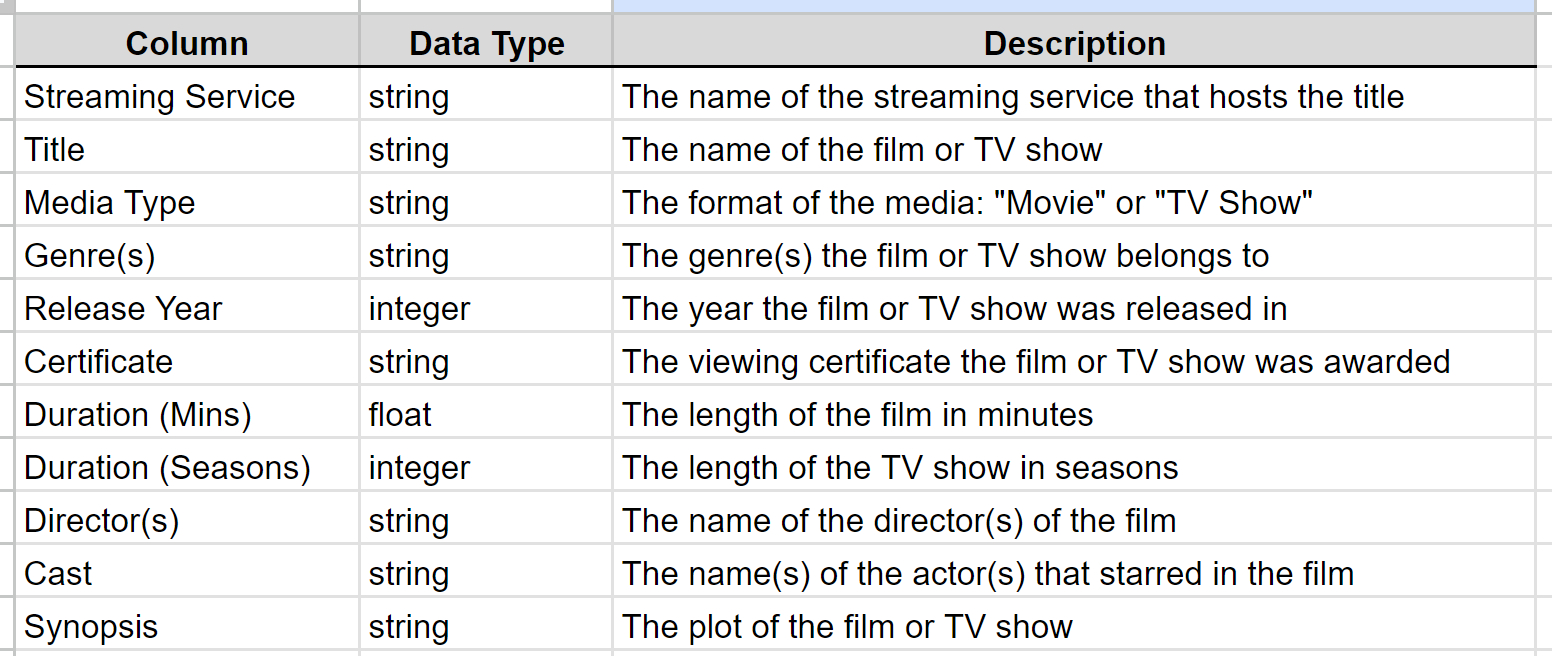

First, create the `Streaming Service` column

In [10]:
for df in dataframes:
    
    value = df['data_source'].str.split('_').str[0].str.capitalize()
    
    if df['data_source'].values[0] == 'amazon_prime_titles':
        value = value + ' Prime'
    else:
        value
    
    df['Streaming Service'] = value
    df.drop(columns=['data_source'], inplace=True)

Next, rename all columns

In [11]:
newColNames = {'type':'Media Type',
               'title':'Title',
               'director':'Director(s)',
               'cast':'Cast',
               'release_year': 'Release Year',
               'rating':'Certificate',
               'duration': 'Duration (Mins)',
               'listed_in': 'Genre(s)',
               'description': 'Synopsis'
              }

for df in dataframes:
    df.rename(columns=newColNames, inplace=True) # rename columns according to staging template

`Duration (Mins)` includes seasons unit for `TV Shows` - these need to be moved into a new column `Duration (Seasons)`

In [12]:
for df in dataframes:
    
    df['Duration (Seasons)'] = '0' # Create new column
    
    # Update new column for TV Shows
    df.loc[df['Media Type'] == 'TV Show', 'Duration (Seasons)'] = df.loc[df['Media Type'] == 'TV Show', 'Duration (Mins)']
    
    # Retrieve only season number
    df['Duration (Seasons)'] = df['Duration (Seasons)'].str.replace('\D', '', regex=True)
    
    # Retrieve only minutes and replace season values as zero
    df['Duration (Mins)'] = df['Duration (Mins)'].str.replace(' min', '')
    df.loc[df['Media Type'] == 'TV Show', 'Duration (Mins)'] = 0

Now, reorder the columns

In [13]:
colOrder = ['Streaming Service', 'Title', 'Media Type', 'Genre(s)', 'Release Year', 'Certificate', 
            'Duration (Mins)', 'Duration (Seasons)','Director(s)', 'Cast', 'Synopsis']

In [14]:
for i, df in enumerate(dataframes):
    dataframes[i] = df[colOrder]

And lastly, update the datatypes

In [15]:
newDataypes = {'Release Year': int, 'Duration (Mins)': float, 'Duration (Seasons)': int}

In [16]:
for df in dataframes:
    for k, v in newDataypes.items():
        df = convertDatatypes(df, k, v)

### Now, three datasets become one clean Masterfile

In [17]:
master_df = pd.concat(dataframes)
master_df.head()

,Streaming Service,Title,Media Type,Genre(s),Release Year,Certificate,Duration (Mins),Duration (Seasons),Director(s),Cast,Synopsis
1,Amazon Prime,Take Care Good Night,Movie,"Drama, International",2018,13+,110.00,0,Girish Joshi,"Mahesh Manjrekar, Abhay Mahajan, Sachin Khedekar",A Metro Family decides to fight a Cyber Crimin...
16,Amazon Prime,Zoombies,Movie,"Horror, Science Fiction",2016,13+,87.00,0,Glenn Miller,"Marcus Anderson, Kaiwi Lyman, Andrew Asper",When a strange virus quickly spreads through a...
17,Amazon Prime,Zoo Babies,TV Show,"Kids, Special Interest",2008,ALL,0.00,1,NaN,Narrator - Gillian Barlett,A heart warming and inspiring series that welc...
18,Amazon Prime,Zoë Coombs Marr: Bossy Bottom,TV Show,"Comedy, Talk Show and Variety",2020,18+,0.00,1,NaN,Zoë Coombs Marr,Zoë Coombs Marr has been on hiatus. Sort of. F...
19,Amazon Prime,Zoe,Movie,Science Fiction,2018,R,104.00,0,Drake Doremus,"Ewan McGregor, Léa Seydoux, Theo James, Mirand...",ZOE tells a tale of forbidden love between an ...


# Save clean files to Processed folder

In [18]:
path = Path('../Processed/streaming-services-clean-masterfile.csv')
master_df.to_csv(path, index=False)